<a href="https://colab.research.google.com/github/Ssamikarann/EEG_EYE/blob/main/EEG_EYE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG EYE Dataset

Data Set Information:

All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and added later manually to the file after analysing the video frames. '1' indicates the eye-closed and '0' the eye-open state. All values are in chronological order with the first measured value at the top of the data.

http://archive.ics.uci.edu/ml/datasets/EEG+Eye+State

Objective : To predict if the eye is closed or open

In [1]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 


In [2]:
from google.colab import files

uploaded = files.upload()

Saving EEG Eye State.arff to EEG Eye State.arff


In [3]:

raw_data = loadarff('EEG Eye State.arff')
df = pd.DataFrame(raw_data[0])

In [4]:
df

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,b'1'
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,b'1'
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,b'1'
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,b'1'


In [5]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  object 
dtypes: float64(14), object(1)
memory usage: 1.7+ MB


## Classification problem

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
## splitting dataset

df['eyeDetection'] = df['eyeDetection'].apply(lambda x: 1 if '1' in str(x) else 0)
train,test = train_test_split(df,train_size=0.75)



In [9]:
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers


In [22]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop(target)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [23]:
batch_size = 32 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, target='eyeDetection' ,batch_size=batch_size)
val_ds = df_to_dataset(test, target='eyeDetection' ,batch_size=batch_size,shuffle=False)

## Creating First TensorFlowModel From Scratch

In [12]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature

In [21]:


all_inputs = []
# Numerical features
for counter,col in enumerate(df.columns):
  if col !='eyeDetection':
      num_feature_col = tf.keras.Input(shape=(1,), name=col)
      all_inputs.append(num_feature_col)
      num_feature_encoded = encode_numerical_feature(num_feature_col, col, train_ds)

      if counter==0:
        all_features = num_feature_encoded
      else:
        all_features=layers.concatenate([all_features,num_feature_encoded])






In [24]:
x = layers.Dense(64, activation="relu")(all_features)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(all_features)
output = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(all_inputs, output)
eval_metrics_list =['accuracy','AUC']

model.compile("adam", "binary_crossentropy", metrics=eval_metrics_list)


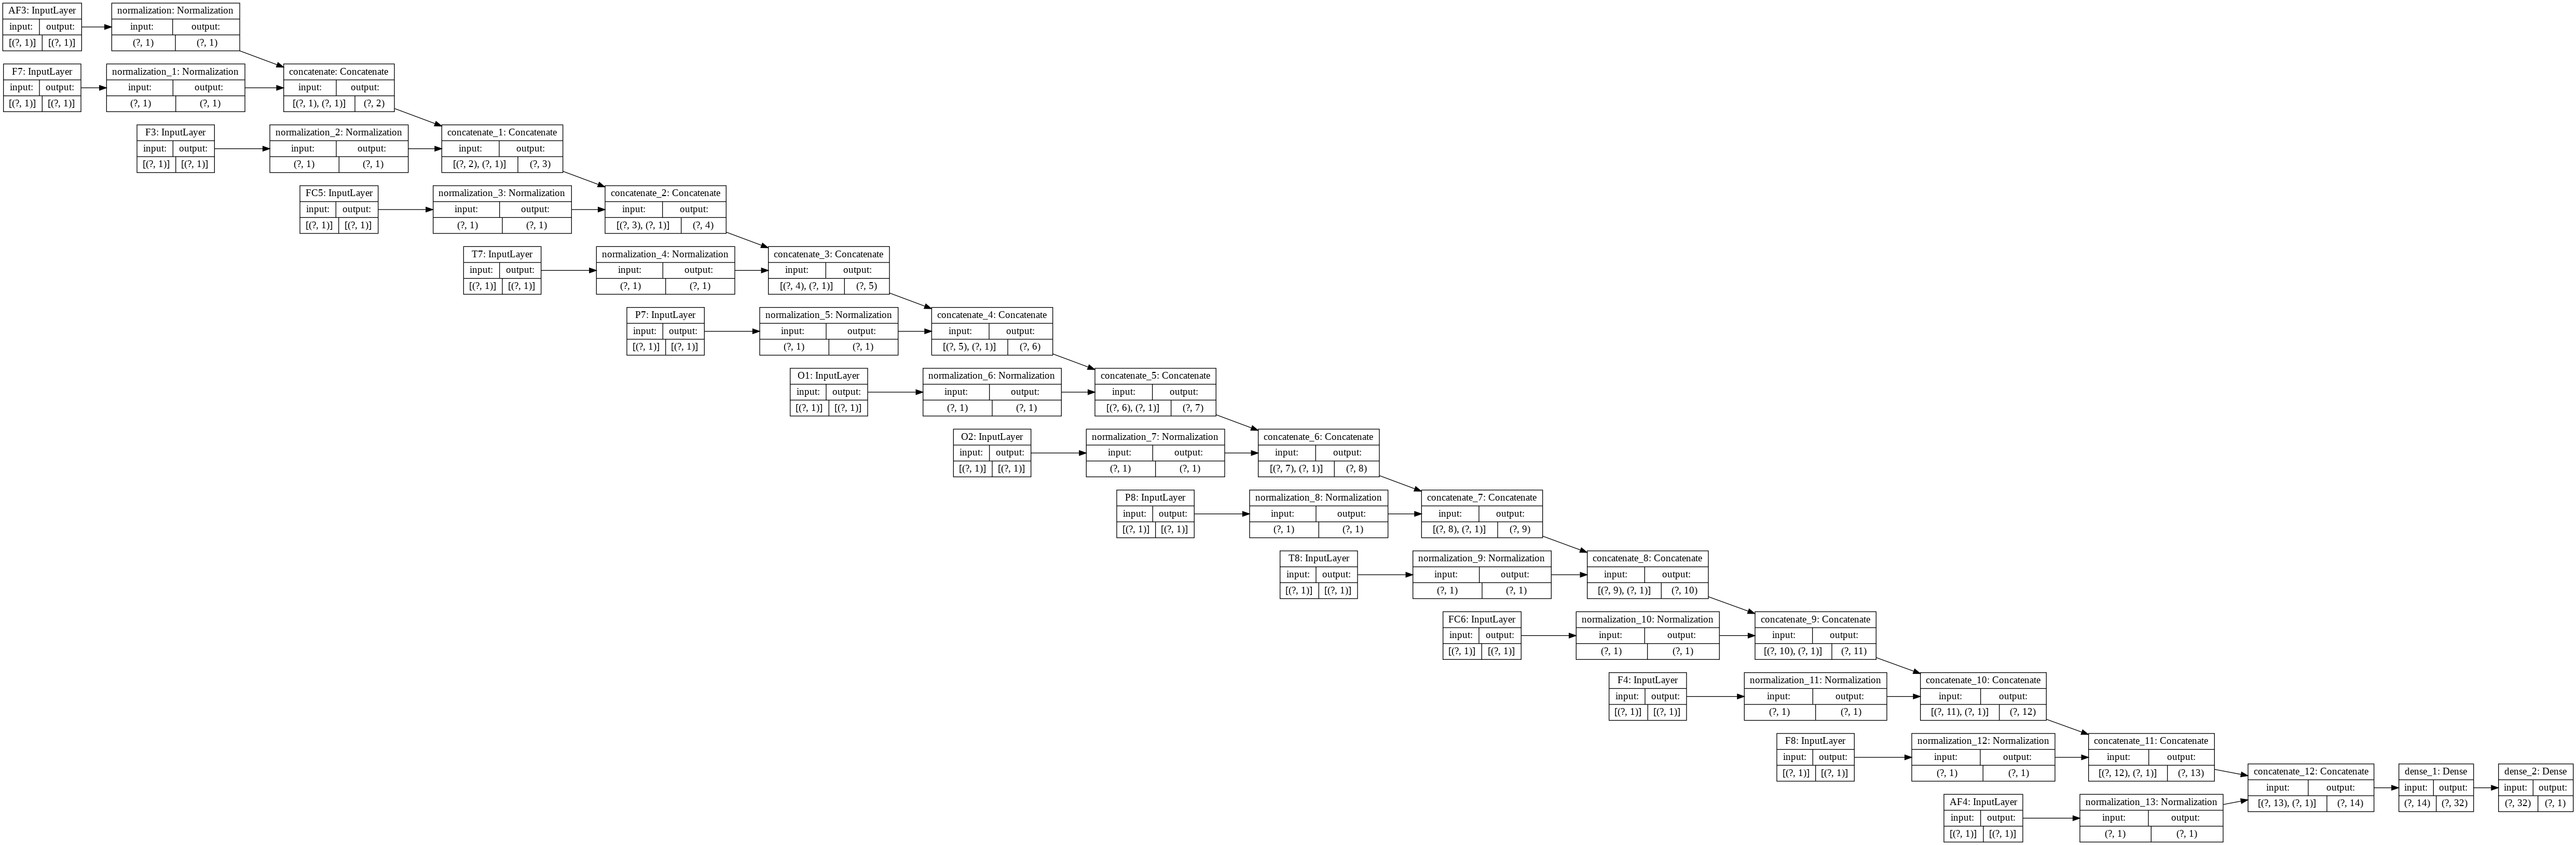

In [15]:
# `rankdir='LR'` is to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [25]:
rcp = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto',
      min_delta=0.0001, cooldown=0, min_lr=0, 
  )
mcp =tf.keras.callbacks.ModelCheckpoint(filepath = 'best_model.h5',save_best_only=True,mode='min',monitor='val_loss',save_weights_only=False)

esp =  tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 100,restore_best_weights=True)


baseline_history= model.fit(train_ds,verbose=0,
              
              validation_data=val_ds, callbacks = [esp,rcp,mcp
                                                  ],
              epochs=1000)

In [26]:
import matplotlib.pyplot as plt

def plot_metrics(history,metrics):
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  metrics = [val.lower() for val in metrics]
  metrics.append('loss')
  plt.figure(figsize=(12,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[n], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[n], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()

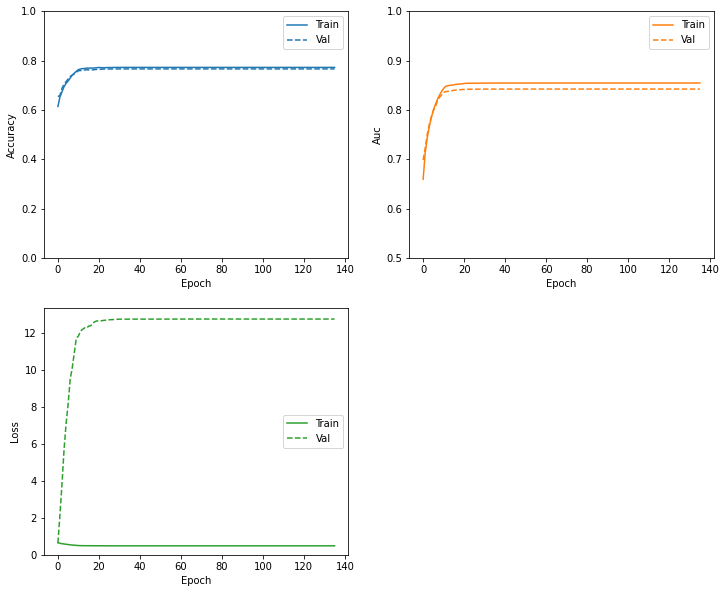

In [29]:
plot_metrics(baseline_history,metrics = eval_metrics_list )

In [30]:
model.evaluate(val_ds)

118/118 [==============================] - 0s 4ms/step - loss: 12.7547 - accuracy: 0.7666 - auc: 0.8424


[12.754738807678223, 0.7666221857070923, 0.8423818349838257]